In [1]:
#增加交叉特征
#Score: Score: 0.89048
#增加G/L
#Score: 0.88750

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib # 注意这个也要import一次
import matplotlib.pyplot as plt 
import seaborn as sns
import pickle
from sklearn import metrics
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, mean_squared_error, roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import lightgbm as lgb

import warnings
warnings.filterwarnings("ignore")

In [3]:
#数据加载
train_data = pd.read_csv('./fraud-detection-in-insurance-claims/train.csv')
test_data = pd.read_csv('./fraud-detection-in-insurance-claims/test.csv')

In [4]:
datas = pd.concat((train_data, test_data))
datas.reset_index(drop=True, inplace=True)

## 数据探索

In [5]:
cat_columns = datas.select_dtypes(include=['O']).columns
numerical_columns = datas.select_dtypes(exclude=['O']).columns

In [6]:
col_name = []
unique_value = []
for col in cat_columns:
    # print(col, datas[col].nunique())
    col_name.append(col)
    unique_value.append(datas[col].nunique())

df_cat_col_unique = pd.DataFrame()
df_cat_col_unique['col_name'] = col_name
df_cat_col_unique['unique_value'] = unique_value
df_cat_col_unique = df_cat_col_unique.sort_values('unique_value', ascending= False)
# df_cat_col_unique

In [7]:
col_name = []
unique_value = []
for col in numerical_columns:
    # print(col, datas[col].nunique())
    col_name.append(col)
    unique_value.append(datas[col].nunique())

df_numerical_col_unique = pd.DataFrame()
df_numerical_col_unique['col_name'] = col_name
df_numerical_col_unique['unique_value'] = unique_value
df_numerical_col_unique = df_numerical_col_unique.sort_values('unique_value', ascending= False)
# df_numerical_col_unique

In [8]:
df_cat_col_unique
# df_numerical_col_unique

,col_name,unique_value
6,incident_location,1000
16,policy_bind_date,951
5,incident_date,60
2,auto_model,39
11,insured_hobbies,20
12,insured_occupation,14
1,auto_make,14
10,insured_education_level,7
4,incident_city,7
8,incident_state,7


## 特征工程

#### 标签编码 policy_bind_date、incident_date

In [9]:
datas['policy_bind_date'] = pd.to_datetime(datas['policy_bind_date'])
datas['incident_date'] = pd.to_datetime(datas['incident_date'])

In [10]:
datas['policy_bind_date_year'] = datas['policy_bind_date'].dt.year
datas['policy_bind_date_month'] = datas['policy_bind_date'].dt.month
datas['policy_bind_date_day'] = datas['policy_bind_date'].dt.day
datas['policy_bind_date_weekday'] = datas['policy_bind_date'].dt.weekday

datas['incident_date_year'] = datas['incident_date'].dt.year
datas['incident_date_month'] = datas['incident_date'].dt.month
datas['incident_date_day'] = datas['incident_date'].dt.day
datas['incident_date_weekday'] = datas['incident_date'].dt.weekday

In [11]:
# 查看最小、最大日期
# datas.policy_bind_date.min() #1990-01-08
# datas.policy_bind_date.max() #2015-02-22

# datas.incident_date.min() #2015-01-01
# datas.incident_date.max() #2015-03-01

In [12]:
base_date = datas.policy_bind_date.min()
#转换为diff
datas['policy_bind_date_diff'] = (datas['policy_bind_date'] - base_date).dt.days
datas['incident_date_diff'] = (datas['incident_date'] - base_date).dt.days
datas['incident_date&policy_bind_date_diff'] = datas['incident_date_diff'] - datas['policy_bind_date_diff']

#### 构造交叉业务特征

In [13]:
datas['injury_claim_pct'] = datas['injury_claim']/datas['total_claim_amount']
datas['property_claim_pct'] = datas['property_claim']/datas['total_claim_amount']
datas['vehicle_claim_pct'] = datas['vehicle_claim']/datas['total_claim_amount']

In [14]:
datas['is_injury_claim'] = datas['injury_claim'].apply(lambda x: '1' if x >0 else '0')
datas['is_property_claim'] = datas['property_claim'].apply(lambda x: '1' if x >0 else '0')
datas['is_vehicle_claim'] = datas['vehicle_claim'].apply(lambda x: '1' if x >0 else '0')

In [15]:
datas['incident_type_&_is_injury_claim'] = datas['incident_type'] + '_' + datas['is_injury_claim']
datas['incident_type_&_is_property_claim'] = datas['incident_type'] + '_' + datas['is_property_claim']
datas['incident_type_&_is_vehicle_claim'] = datas['incident_type'] + '_' + datas['is_vehicle_claim']

datas['collision_type_&_is_injury_claim'] = datas['collision_type'] + '_' + datas['is_injury_claim']
datas['collision_type_&_is_property_claim'] = datas['collision_type'] + '_' + datas['is_property_claim']
datas['collision_type_&_is_vehicle_claim'] = datas['collision_type'] + '_' + datas['is_vehicle_claim']

In [16]:
datas['umbrella_limit_2_total_claim_amount'] = datas['umbrella_limit']/datas['total_claim_amount']

In [17]:
datas['G/L'] = datas['capital-gains'] - datas['capital-loss']

In [18]:
# datas[['incident_type', 'collision_type', 'policy_csl', 'policy_annual_premium', 'umbrella_limit', 'total_claim_amount', 'injury_claim', 'property_claim', 'vehicle_claim', 'capital-gains', 'capital-loss']][datas['fraud_reported'] > 0]

In [19]:
#检查单个特征
# datas.incident_city.nunique()
# datas['incident_type'].value_counts()

In [20]:
datas.drop(['policy_bind_date', 'incident_date', '_c39', 'incident_location', 'policy_number', 'insured_zip'], axis= 1, inplace=True)

In [21]:
from sklearn.preprocessing import LabelEncoder

In [22]:
cat_columns = datas.select_dtypes(include= ['O']).columns

In [23]:
for col in cat_columns:
    le = LabelEncoder()
    datas[col] = le.fit_transform(datas[col])

datas[cat_columns]

,authorities_contacted,auto_make,auto_model,collision_type,incident_city,incident_severity,incident_state,incident_type,insured_education_level,insured_hobbies,...,property_damage,is_injury_claim,is_property_claim,is_vehicle_claim,incident_type_&_is_injury_claim,incident_type_&_is_property_claim,incident_type_&_is_vehicle_claim,collision_type_&_is_injury_claim,collision_type_&_is_property_claim,collision_type_&_is_vehicle_claim
0,0,9,26,3,5,2,0,2,5,15,...,0,1,1,0,5,5,2,7,7,3
1,3,6,10,3,6,1,0,0,3,14,...,0,1,1,0,1,1,0,7,7,3
2,4,7,36,3,3,2,6,2,2,16,...,0,1,1,0,5,5,2,7,7,3
3,1,11,21,1,3,0,6,0,3,18,...,2,1,1,0,1,1,0,3,3,1
4,1,5,14,2,3,2,4,0,4,18,...,2,1,1,0,1,1,0,5,5,2
5,4,10,2,2,6,0,4,0,3,17,...,2,1,1,0,1,1,0,5,5,2
6,1,12,18,3,0,2,1,0,6,9,...,0,1,1,0,1,1,0,7,7,3
7,0,11,21,3,1,1,6,0,6,3,...,1,1,1,0,1,1,0,7,7,3
8,0,4,30,2,2,2,4,0,4,18,...,1,1,1,0,1,1,0,5,5,2
9,0,10,1,1,1,0,1,0,2,4,...,0,1,1,0,1,1,0,3,3,1


In [24]:
# 数据集切分
train = datas[datas['fraud_reported'].notnull()]
test = datas[datas['fraud_reported'].isnull()]

In [25]:
train_X = train.drop(['fraud_reported'], axis=1)
train_y = train['fraud_reported']
test_X = test.drop(['fraud_reported'], axis=1)

## 使用lgbm 训练

In [26]:
import lightgbm as lgb

In [27]:
model_lgb = lgb.LGBMClassifier(
            num_leaves=2**5-1, reg_alpha=0.25, reg_lambda=0.25, objective='binary',
            max_depth=-1, learning_rate=0.005, min_child_samples=3, random_state=2022,
            n_estimators=2000, subsample=1, colsample_bytree=1,
        )

In [28]:
model_lgb.fit(train_X, train_y)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1,
        importance_type='split', learning_rate=0.005, max_depth=-1,
        min_child_samples=3, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=2000, n_jobs=-1, num_leaves=31, objective='binary',
        random_state=2022, reg_alpha=0.25, reg_lambda=0.25, silent=True,
        subsample=1, subsample_for_bin=200000, subsample_freq=0)

In [29]:
y_pred = model_lgb.predict_proba(test_X)[:, 1]

In [30]:
y_pred

array([  1.43200280e-02,   2.76675459e-01,   6.53362381e-03,
         2.07723219e-02,   1.41789871e-03,   3.38141522e-02,
         2.83379494e-03,   1.01300523e-02,   1.11230568e-03,
         3.02572643e-03,   8.30768806e-02,   4.03885067e-03,
         6.89784845e-01,   2.60458689e-03,   4.17530612e-03,
         7.29708333e-01,   5.28748927e-03,   5.44201967e-03,
         5.99926831e-01,   6.22140610e-03,   6.29354956e-03,
         4.77852224e-01,   8.78733495e-01,   1.05907658e-02,
         7.26807791e-03,   9.46566538e-01,   1.84318816e-03,
         6.59380162e-03,   1.19300780e-01,   8.28235076e-02,
         9.05676729e-01,   3.07510183e-02,   4.33489158e-01,
         3.81696981e-03,   7.95082694e-03,   1.48248470e-02,
         7.36086377e-01,   3.67452686e-03,   1.85475768e-03,
         7.70457917e-02,   5.90402943e-01,   5.40618918e-03,
         9.00658441e-03,   1.07107412e-02,   7.33583965e-03,
         4.85994644e-03,   4.89942166e-03,   2.75413801e-02,
         5.93645246e-01,

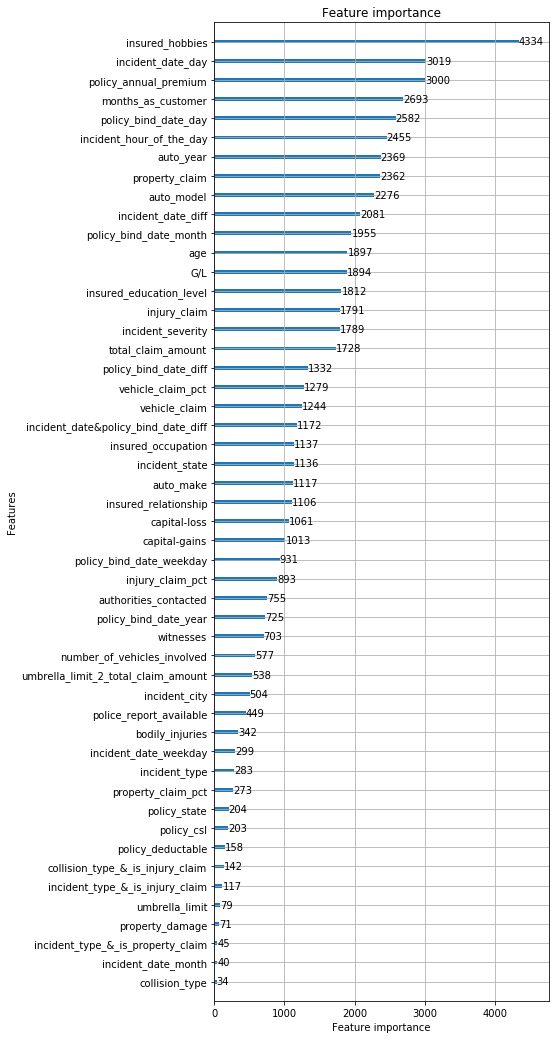

In [31]:
fig, ax = plt.subplots(figsize=(6,18))
lgb.plot_importance(model_lgb, max_num_features=60, ax = ax)

In [32]:
submission = pd.read_csv('./fraud-detection-in-insurance-claims/sampleSubmission.csv')
submission['fraud_reported'] = y_pred
submission.to_csv('./submission/submission.csv', index=None)